<a href="https://colab.research.google.com/github/mahoangnhatphi/big-data/blob/main/Analyzing_Sales_Data_with_Apache_Spark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1

Dataset: https://www.kaggle.com/datasets/kyanyoga/sample-sales-data/data

Mã Hoàng Nhật Phi

## Set up

In [1]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"
import findspark
findspark.init()

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,349 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,843 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/restricte

In [2]:
!pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"phimhongnht","key":"b82d9ed25397dba619eb021468823170"}'}

In [37]:
## Import python
import pandas as pd
import numpy as np
import sklearn
from scipy import stats
import matplotlib.pyplot as plt
import os
import seaborn as sns

## 1.Data Preparation:

### Load the sales dataset into Spark RDDs or DataFrames.

In [8]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d kyanyoga/sample-sales-data

!unzip "sample-sales-data.zip"

sample-sales-data.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  sample-sales-data.zip
  inflating: sales_data_sample.csv   


In [4]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession

In [5]:
sc = SparkContext(conf=SparkConf())
spark = SparkSession(sparkContext=sc)

In [6]:
import pandas as pd
print('Pandas version: {}'. format(pd.__version__))

Pandas version: 1.5.3


In [9]:
data_raw = spark.read.csv('/content/sales_data_sample.csv', inferSchema=True, header=True)

# preview the data
# data type
print('-'*10, 'data types', '-'*10)
pd.DataFrame(data_raw.dtypes)

---------- data types ----------


0       1
0        ORDERNUMBER     int
1    QUANTITYORDERED     int
2          PRICEEACH  double
3    ORDERLINENUMBER     int
4              SALES  double
5          ORDERDATE  string
6             STATUS  string
7             QTR_ID     int
8           MONTH_ID     int
9            YEAR_ID     int
10       PRODUCTLINE  string
11              MSRP     int
12       PRODUCTCODE  string
13      CUSTOMERNAME  string
14             PHONE  string
15      ADDRESSLINE1  string
16      ADDRESSLINE2  string
17              CITY  string
18             STATE  string
19        POSTALCODE  string
20           COUNTRY  string
21         TERRITORY  string
22   CONTACTLASTNAME  string
23  CONTACTFIRSTNAME  string
24          DEALSIZE  string

In [10]:
raw_df = data_raw.toPandas()
df = raw_df.copy()
df.head()

ORDERNUMBER  QUANTITYORDERED  PRICEEACH  ORDERLINENUMBER    SALES  \
0        10107               30      95.70                2  2871.00   
1        10121               34      81.35                5  2765.90   
2        10134               41      94.74                2  3884.34   
3        10145               45      83.26                6  3746.70   
4        10159               49     100.00               14  5205.27   

         ORDERDATE   STATUS  QTR_ID  MONTH_ID  YEAR_ID  ...  \
0   2/24/2003 0:00  Shipped       1         2     2003  ...   
1    5/7/2003 0:00  Shipped       2         5     2003  ...   
2    7/1/2003 0:00  Shipped       3         7     2003  ...   
3   8/25/2003 0:00  Shipped       3         8     2003  ...   
4  10/10/2003 0:00  Shipped       4        10     2003  ...   

                    ADDRESSLINE1  ADDRESSLINE2           CITY STATE  \
0        897 Long Airport Avenue          None            NYC    NY   
1             59 rue de l'Abbaye          None          Reims  None   
2  27 rue du Colonel Pierre Avia          None          Paris  None   
3             78934 Hillside Dr.          None       Pasadena    CA   
4                7734 Strong St.          None  San Francisco    CA   

  POSTALCODE COUNTRY TERRITORY CONTACTLASTNAME CONTACTFIRSTNAME DEALSIZE  
0      10022     USA        NA              Yu             Kwai    Small  
1      51100  France      EMEA         Henriot             Paul    Small  
2      75508  France      EMEA        Da Cunha           Daniel   Medium  
3      90003     USA        NA           Young            Julie   Medium  
4       None     USA        NA           Brown            Julie   Medium  

[5 rows x 25 columns]

In [11]:
# data summary
print('-'*10, 'data summary', '-'*10)
data_raw.describe().toPandas()

---------- data summary ----------


summary         ORDERNUMBER    QUANTITYORDERED           PRICEEACH  \
0   count                2823               2823                2823   
1    mean  10258.725115125753  35.09280906836698   83.65854410201929   
2  stddev    92.0854775957196   9.74144273706958  20.174276527840536   
3     min               10100                  6               26.88   
4     max               10425                 97               100.0   

     ORDERLINENUMBER               SALES       ORDERDATE     STATUS  \
0               2823                2823            2823       2823   
1  6.466170740347148    3553.88907190932            None       None   
2   4.22584096469094  1841.8651057401842            None       None   
3                  1              482.13  1/10/2003 0:00  Cancelled   
4                 18             14082.8   9/9/2004 0:00    Shipped   

               QTR_ID            MONTH_ID  ...           ADDRESSLINE1  \
0                2823                2823  ...                   2823   
1  2.7176762309599716  7.0924548352816155  ...                   None   
2   1.203878088001756   3.656633307661765  ...                   None   
3                   1                   1  ...  1 rue Alsace-Lorraine   
4                   4                  12  ...           Vinb'ltet 34   

  ADDRESSLINE2          CITY     STATE          POSTALCODE    COUNTRY  \
0          302          2823      1337                2747       2823   
1         None          None      None  46823.061787905346       None   
2         None          None      None   33486.50903171618       None   
3    2nd Floor       Aaarhus        BC               10022  Australia   
4    Suite 750  White Plains  Victoria             WX3 6FW        USA   

  TERRITORY CONTACTLASTNAME CONTACTFIRSTNAME DEALSIZE  
0      2823            2823             2823     2823  
1      None            None             None     None  
2      None            None             None     None  
3      APAC         Accorti           Adrian    Large  
4        NA              Yu            Yoshi    Small  

[5 rows x 26 columns]

In [12]:
# view a small subset of the data
print('-'*10, 'randomely sample 1% data to view', '-'*10)
data_raw.randomSplit([0.01, 0.99])[0].toPandas()

---------- randomely sample 1% data to view ----------


ORDERNUMBER  QUANTITYORDERED  PRICEEACH  ORDERLINENUMBER    SALES  \
0         10143               46      74.84               13  3442.64   
1         10147               31     100.00                5  3494.94   
2         10147               37     100.00                9  4405.22   
3         10184               42      31.82                7  1336.44   
4         10196               49     100.00                1  6893.81   
5         10197               29      41.71                1  1209.59   
6         10210               43      41.02               11  1763.86   
7         10236               22     100.00                1  2852.08   
8         10263               40     100.00                5  4472.00   
9         10266               44     100.00               14  9160.36   
10        10280               37     100.00               13  4750.80   
11        10287               36      39.65                6  1427.40   
12        10301               23     100.00                9  4011.66   
13        10304               23      30.20               16   694.60   
14        10315               40      55.69                5  2227.60   
15        10318               26      86.83                6  2257.58   
16        10324               38     100.00                6  6832.02   
17        10329               46      83.63               13  3846.98   
18        10359               25      64.93                4  1623.25   
19        10363               22     100.00                7  3686.54   
20        10368               40     100.00                2  4107.20   
21        10384               49     100.00                1  6397.44   
22        10385               37      85.54                2  3164.98   
23        10386               37      83.84               14  3102.08   
24        10386               50      87.15               16  4357.50   
25        10412               19      48.70                7   925.30   
26        10416               37      51.93                8  1921.41   
27        10425               28     100.00                8  3793.16   

          ORDERDATE      STATUS  QTR_ID  MONTH_ID  YEAR_ID  ...  \
0    8/10/2003 0:00     Shipped       3         8     2003  ...   
1     9/5/2003 0:00     Shipped       3         9     2003  ...   
2     9/5/2003 0:00     Shipped       3         9     2003  ...   
3   11/14/2003 0:00     Shipped       4        11     2003  ...   
4   11/26/2003 0:00     Shipped       4        11     2003  ...   
5   11/26/2003 0:00     Shipped       4        11     2003  ...   
6    1/12/2004 0:00     Shipped       1         1     2004  ...   
7     4/3/2004 0:00     Shipped       2         4     2004  ...   
8    6/28/2004 0:00     Shipped       2         6     2004  ...   
9     7/6/2004 0:00     Shipped       3         7     2004  ...   
10   8/17/2004 0:00     Shipped       3         8     2004  ...   
11   8/30/2004 0:00     Shipped       3         8     2004  ...   
12   10/5/2003 0:00     Shipped       4        10     2003  ...   
13  10/11/2004 0:00     Shipped       4        10     2004  ...   
14  10/29/2004 0:00     Shipped       4        10     2004  ...   
15   11/2/2004 0:00     Shipped       4        11     2004  ...   
16   11/5/2004 0:00     Shipped       4        11     2004  ...   
17  11/15/2004 0:00     Shipped       4        11     2004  ...   
18  12/15/2004 0:00     Shipped       4        12     2004  ...   
19    1/6/2005 0:00     Shipped       1         1     2005  ...   
20   1/19/2005 0:00     Shipped       1         1     2005  ...   
21   2/23/2005 0:00     Shipped       1         2     2005  ...   
22   2/28/2005 0:00     Shipped       1         2     2005  ...   
23    3/1/2005 0:00    Resolved       1         3     2005  ...   
24    3/1/2005 0:00    Resolved       1         3     2005  ...   
25    5/3/2005 0:00     Shipped       2         5     2005  ...   
26   5/10/2005 0:00     Shipped       2         5     2005  ...   
27   5/31/

In [13]:
df.shape

(2823, 25)

In [14]:
df.head()

ORDERNUMBER  QUANTITYORDERED  PRICEEACH  ORDERLINENUMBER    SALES  \
0        10107               30      95.70                2  2871.00   
1        10121               34      81.35                5  2765.90   
2        10134               41      94.74                2  3884.34   
3        10145               45      83.26                6  3746.70   
4        10159               49     100.00               14  5205.27   

         ORDERDATE   STATUS  QTR_ID  MONTH_ID  YEAR_ID  ...  \
0   2/24/2003 0:00  Shipped       1         2     2003  ...   
1    5/7/2003 0:00  Shipped       2         5     2003  ...   
2    7/1/2003 0:00  Shipped       3         7     2003  ...   
3   8/25/2003 0:00  Shipped       3         8     2003  ...   
4  10/10/2003 0:00  Shipped       4        10     2003  ...   

                    ADDRESSLINE1  ADDRESSLINE2           CITY STATE  \
0        897 Long Airport Avenue          None            NYC    NY   
1             59 rue de l'Abbaye          None          Reims  None   
2  27 rue du Colonel Pierre Avia          None          Paris  None   
3             78934 Hillside Dr.          None       Pasadena    CA   
4                7734 Strong St.          None  San Francisco    CA   

  POSTALCODE COUNTRY TERRITORY CONTACTLASTNAME CONTACTFIRSTNAME DEALSIZE  
0      10022     USA        NA              Yu             Kwai    Small  
1      51100  France      EMEA         Henriot             Paul    Small  
2      75508  France      EMEA        Da Cunha           Daniel   Medium  
3      90003     USA        NA           Young            Julie   Medium  
4       None     USA        NA           Brown            Julie   Medium  

[5 rows x 25 columns]

### Cleanse the data by handling missing values, outliers, or any inconsistencies.

Checking for null values

In [15]:
total_null = df.isnull().sum().sort_values(ascending = False)
percent_null = (df.isnull().sum()/df.isnull().count()).sort_values(ascending = False)
missing_data = pd.concat([total_null,percent_null],axis = 1,keys=['total_null','persent_null'])
missing_data

total_null  persent_null
ADDRESSLINE2            2521      0.893022
STATE                   1486      0.526390
POSTALCODE                76      0.026922
ORDERNUMBER                0      0.000000
CUSTOMERNAME               0      0.000000
CONTACTFIRSTNAME           0      0.000000
CONTACTLASTNAME            0      0.000000
TERRITORY                  0      0.000000
COUNTRY                    0      0.000000
CITY                       0      0.000000
ADDRESSLINE1               0      0.000000
PHONE                      0      0.000000
PRODUCTCODE                0      0.000000
QUANTITYORDERED            0      0.000000
MSRP                       0      0.000000
PRODUCTLINE                0      0.000000
YEAR_ID                    0      0.000000
MONTH_ID                   0      0.000000
QTR_ID                     0      0.000000
STATUS                     0      0.000000
ORDERDATE                  0      0.000000
SALES                      0      0.000000
ORDERLINENUMBER            0      0.000000
PRICEEACH                  0      0.000000
DEALSIZE                   0      0.000000

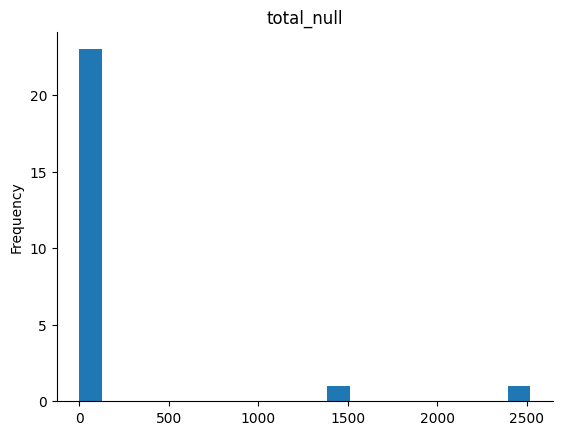

In [18]:
### Total null

from matplotlib import pyplot as plt
missing_data['total_null'].plot(kind='hist', bins=20, title='total_null')
plt.gca().spines[['top', 'right',]].set_visible(False)

Dropping columns

In [19]:
#Removing the variables which dont add significant value to the analysis or majority null value.
to_drop = ['PHONE','ADDRESSLINE1','ADDRESSLINE2','STATE','POSTALCODE','TERRITORY']
df = df.drop(to_drop, axis=1)

Checking for inconsistent data types

In [20]:
df.dtypes

ORDERNUMBER           int32
QUANTITYORDERED       int32
PRICEEACH           float64
ORDERLINENUMBER       int32
SALES               float64
ORDERDATE            object
STATUS               object
QTR_ID                int32
MONTH_ID              int32
YEAR_ID               int32
PRODUCTLINE          object
MSRP                  int32
PRODUCTCODE          object
CUSTOMERNAME         object
CITY                 object
COUNTRY              object
CONTACTLASTNAME      object
CONTACTFIRSTNAME     object
DEALSIZE             object
dtype: object

In [21]:
df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'])

Summary stats of Quantitative variables

In [22]:
quant_vars = ['QUANTITYORDERED','PRICEEACH','SALES','MSRP']
df[quant_vars].describe()

QUANTITYORDERED    PRICEEACH         SALES         MSRP
count      2823.000000  2823.000000   2823.000000  2823.000000
mean         35.092809    83.658544   3553.889072   100.715551
std           9.741443    20.174277   1841.865106    40.187912
min           6.000000    26.880000    482.130000    33.000000
25%          27.000000    68.860000   2203.430000    68.000000
50%          35.000000    95.700000   3184.800000    99.000000
75%          43.000000   100.000000   4508.000000   124.000000
max          97.000000   100.000000  14082.800000   214.000000

In [23]:
df.sort_values(by = ['ORDERDATE'], inplace = True)
df.set_index('ORDERDATE', inplace = True)

In [24]:
df.head()

ORDERNUMBER  QUANTITYORDERED  PRICEEACH  ORDERLINENUMBER    SALES  \
ORDERDATE                                                                       
2003-01-06        10100               30     100.00                3  5151.00   
2003-01-06        10100               50      67.80                2  3390.00   
2003-01-06        10100               22      86.51                4  1903.22   
2003-01-06        10100               49      34.47                1  1689.03   
2003-01-09        10101               45      31.20                3  1404.00   

             STATUS  QTR_ID  MONTH_ID  YEAR_ID   PRODUCTLINE  MSRP  \
ORDERDATE                                                            
2003-01-06  Shipped       1         1     2003  Vintage Cars   170   
2003-01-06  Shipped       1         1     2003  Vintage Cars    60   
2003-01-06  Shipped       1         1     2003  Vintage Cars    92   
2003-01-06  Shipped       1         1     2003  Vintage Cars    41   
2003-01-09  Shipped       1         1     2003  Vintage Cars    33   

           PRODUCTCODE                  CUSTOMERNAME       CITY  COUNTRY  \
ORDERDATE                                                                  
2003-01-06    S18_1749  Online Diecast Creations Co.     Nashua      USA   
2003-01-06    S18_2248  Online Diecast Creations Co.     Nashua      USA   
2003-01-06    S18_4409  Online Diecast Creations Co.     Nashua      USA   
2003-01-06    S24_3969  Online Diecast Creations Co.     Nashua      USA   
2003-01-09    S24_1937          Blauer See Auto, Co.  Frankfurt  Germany   

           CONTACTLASTNAME CONTACTFIRSTNAME DEALSIZE  
ORDERDATE                                             
2003-01-06           Young          Valarie   Medium  
2003-01-06           Young          Valarie   Medium  
2003-01-06           Young          Valarie    Small  
2003-01-06           Young          Valarie    Small  
2003-01-09          Keitel           Roland    Small

## EDA - Exploratory Data Analysis and Visualization

<ipython-input-80-2278698e06fb>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['QUANTITYORDERED'],bins=30)


<Axes: xlabel='QUANTITYORDERED', ylabel='Density'>

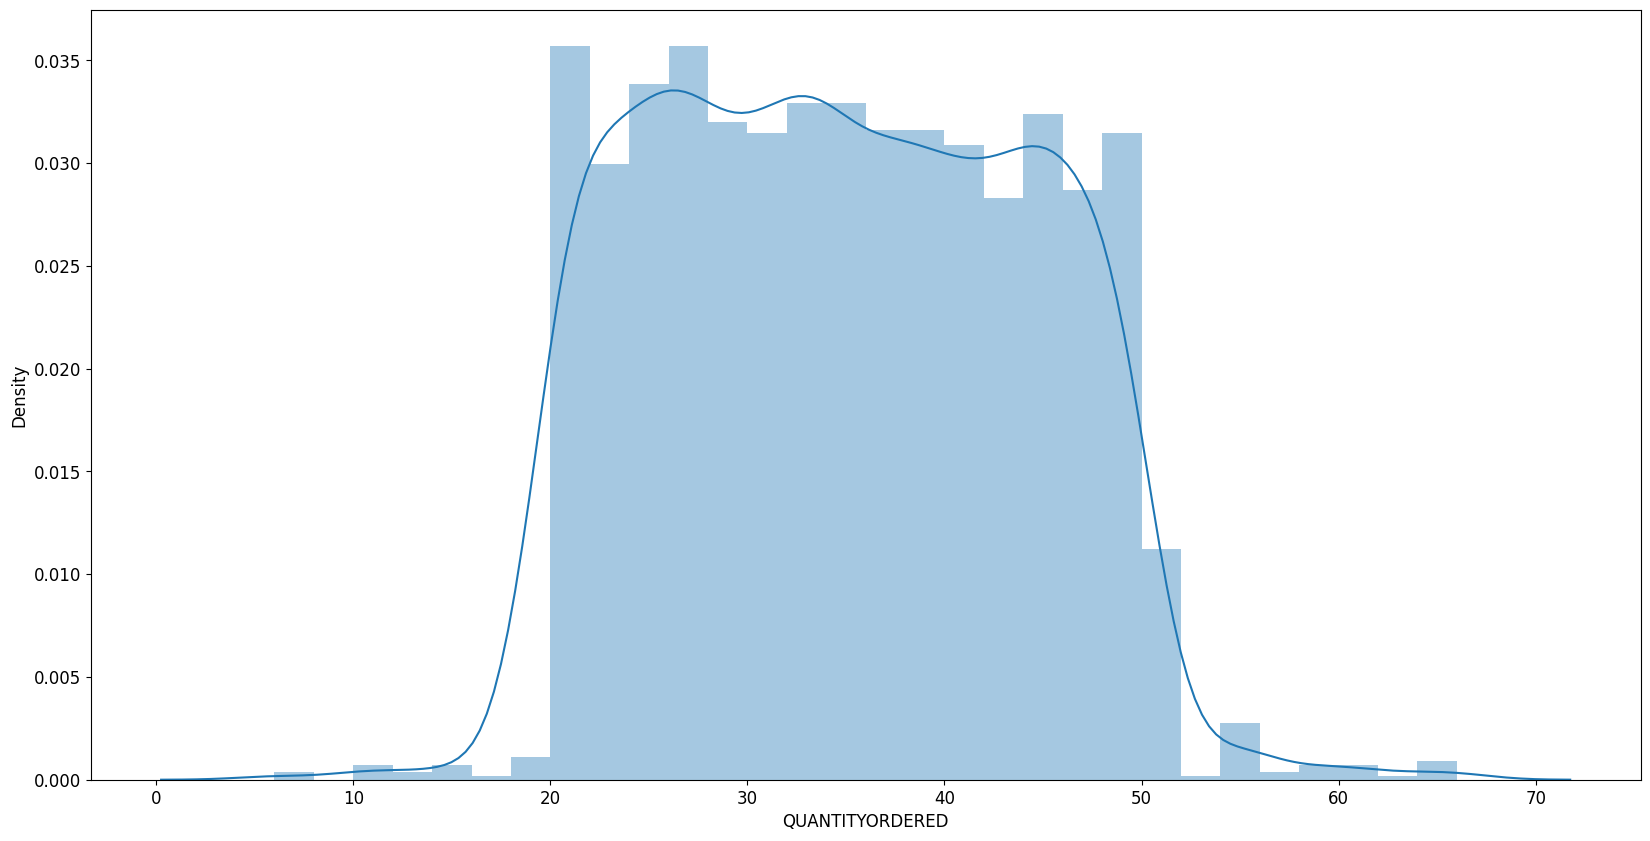

In [80]:
sns.distplot(df['QUANTITYORDERED'],bins=30)

<Axes: xlabel='SALES', ylabel='Count'>

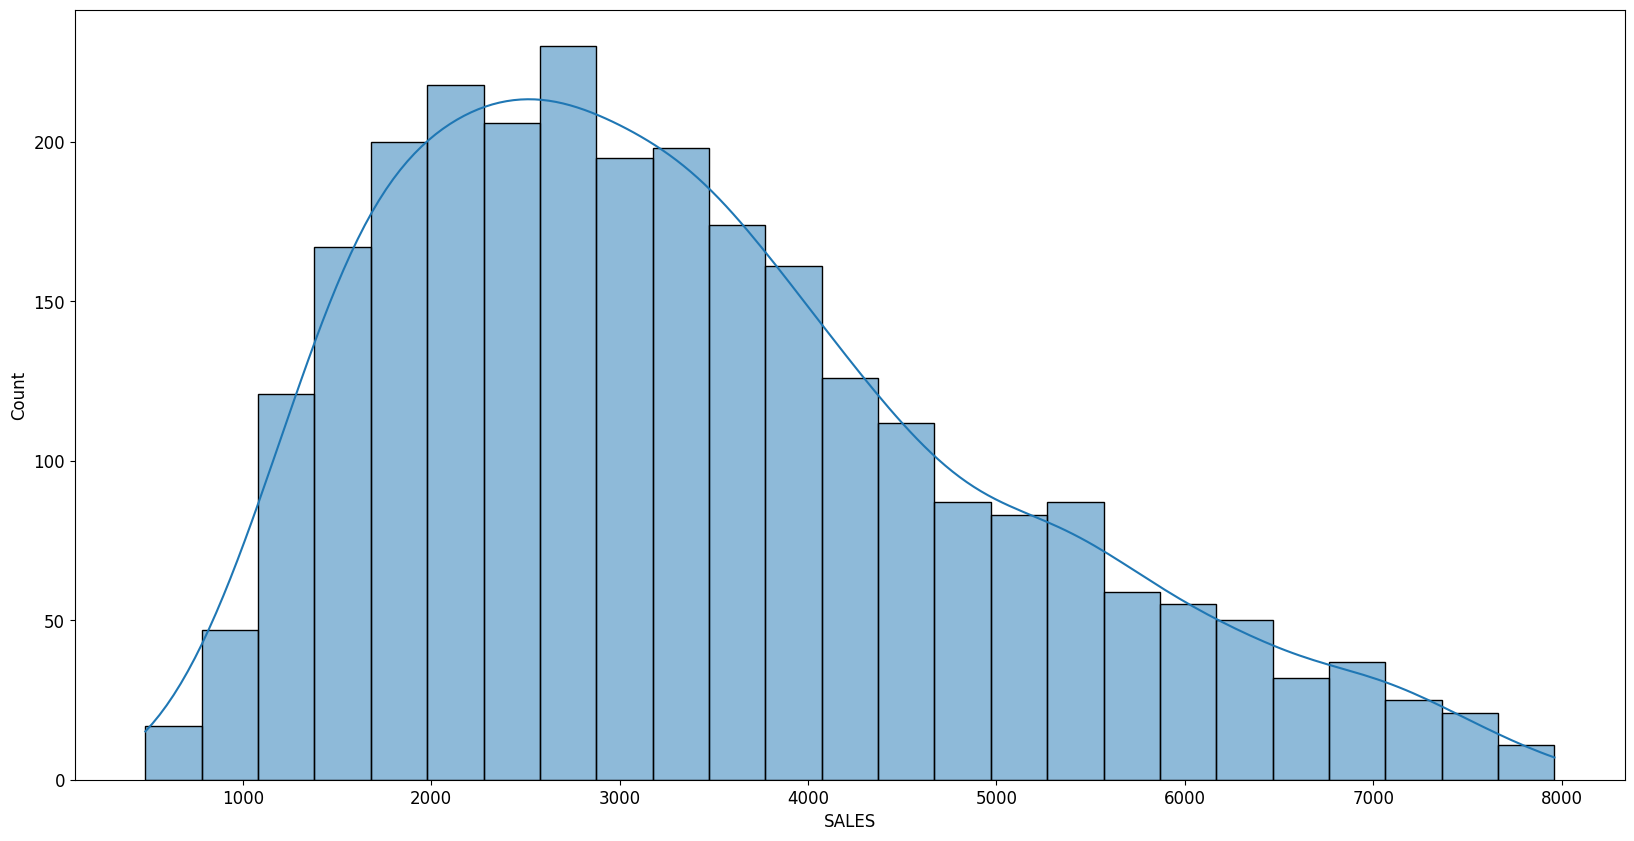

In [81]:
sns.histplot(df['SALES'],kde=True)

Outliers, data points far from the norm, can be found visually (box plots!) or mathematically (IQR).  Consider removing them only if sure they're errors.

Box Plots: Show quartiles (data spread) with outliers as separate points. Anything beyond 1.5x IQR from quartiles (Q1 & Q3) is an outlier.

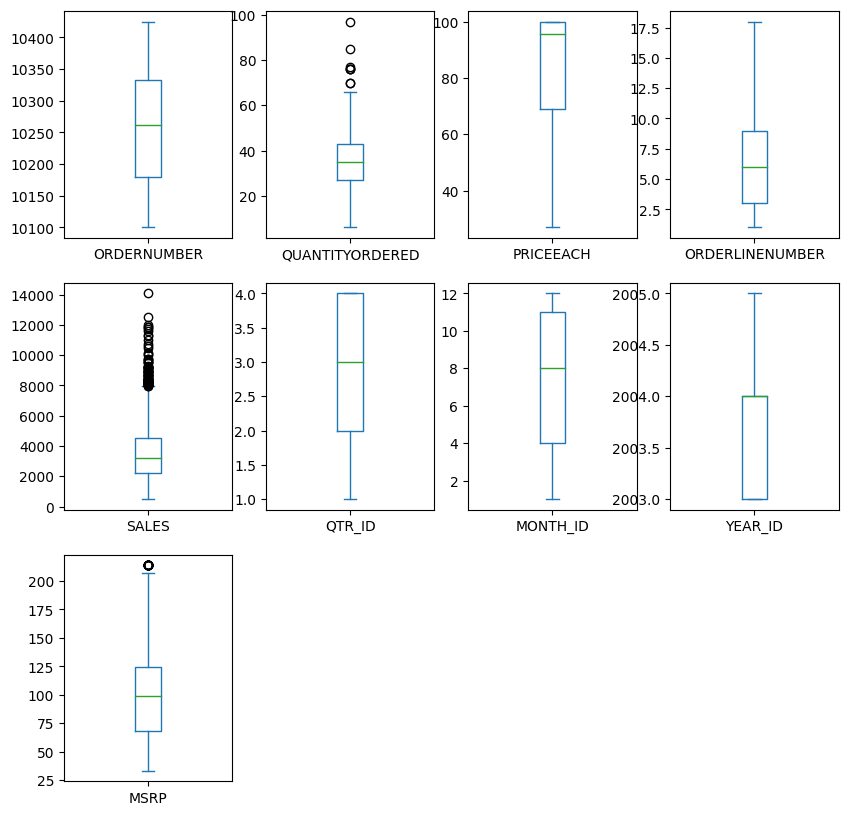

In [25]:
import matplotlib.pyplot as plt

df.plot(kind='box', subplots=True, sharex=False, sharey=False, figsize=(10,10), layout=(3,4))
plt.show()

In [26]:
top_customer = df.groupby(['CUSTOMERNAME']).sum().sort_values('SALES', ascending = False).head(20)
top_customer = top_customer[['SALES']].round(3)
top_customer.reset_index(inplace = True)

<ipython-input-26-2ce45ee0a055>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  top_customer = df.groupby(['CUSTOMERNAME']).sum().sort_values('SALES', ascending = False).head(20)


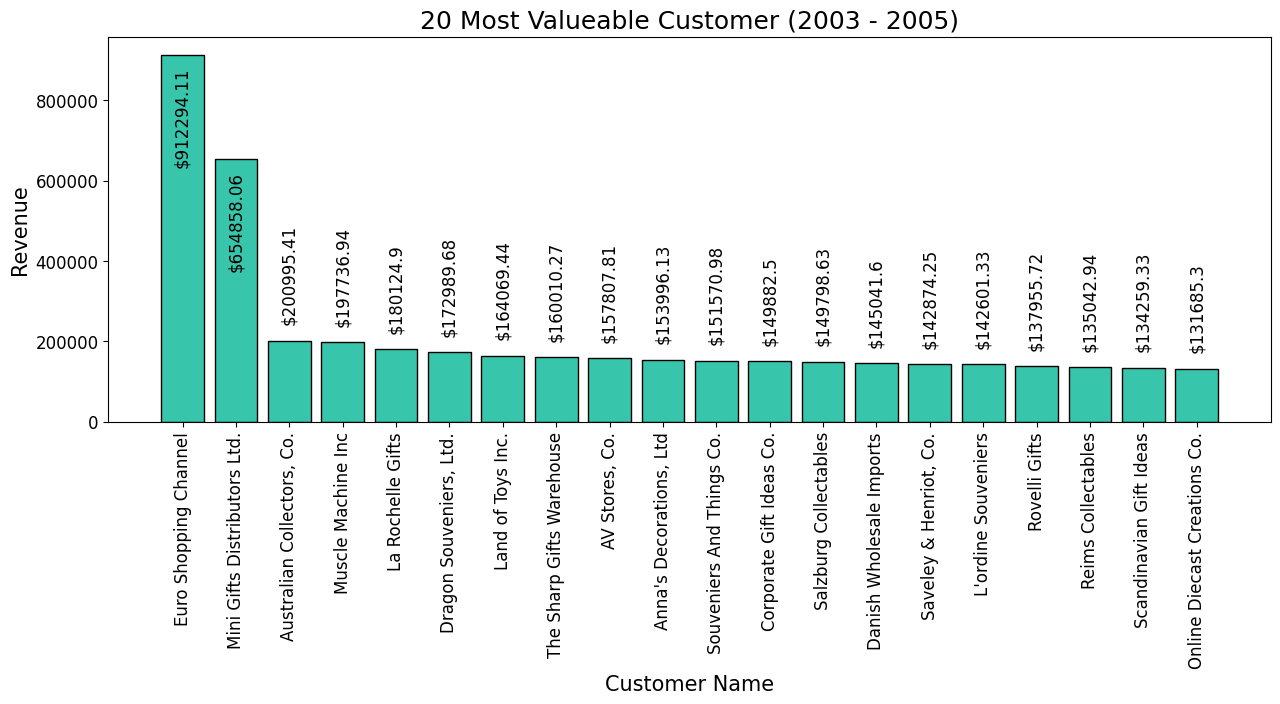

In [27]:
plt.figure(figsize = (15,5))
plt.title('20 Most Valueable Customer (2003 - 2005)', fontsize = 18)
plt.bar(top_customer['CUSTOMERNAME'], top_customer['SALES'], color = '#37C6AB', edgecolor = 'black', linewidth = 1)
plt.xlabel('Customer Name', fontsize = 15)
plt.ylabel('Revenue', fontsize = 15)
plt.xticks(fontsize = 12, rotation = 90)
plt.yticks(fontsize = 12)
for k, v in top_customer['SALES'].items():
    if v > 600000:
        plt.text(k, v-270000, '$' + str(v), fontsize = 12, rotation = 90, color = 'black', ha = 'center')
    else:
        plt.text(k, v+ 50000, '$' + str(v), fontsize = 12, rotation = 90, color = 'black', ha = 'center')

In [28]:
top_country = df.groupby(['COUNTRY']).sum().sort_values('SALES', ascending = False).head(20)
top_country = top_country[['SALES']].round(3)
top_country.reset_index(inplace = True)

<ipython-input-28-600940bddf50>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  top_country = df.groupby(['COUNTRY']).sum().sort_values('SALES', ascending = False).head(20)


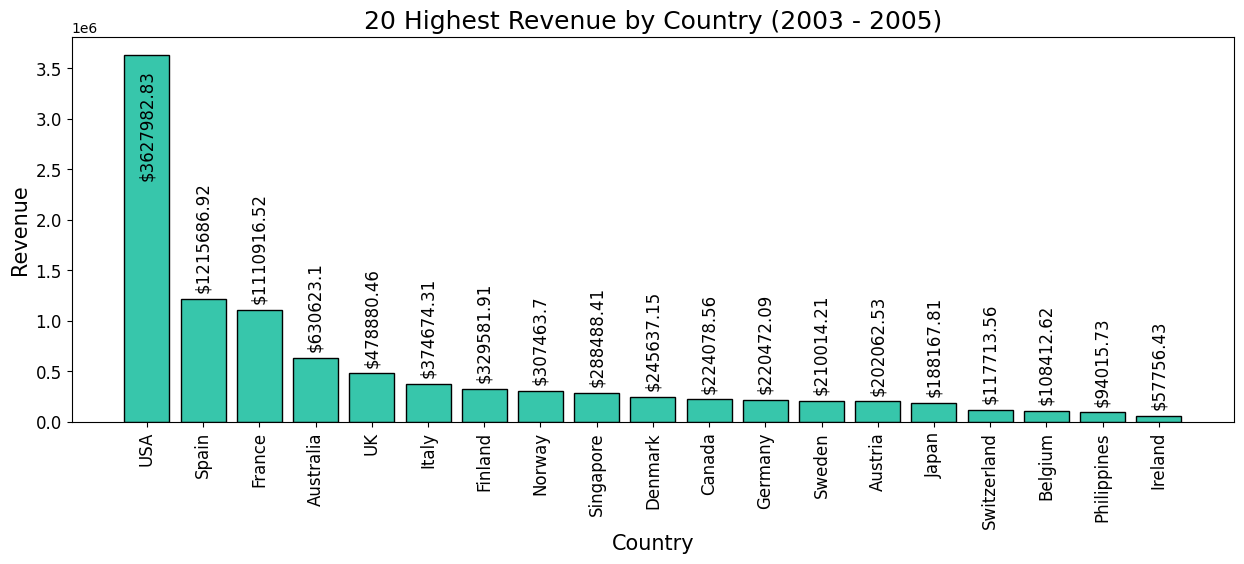

In [29]:
plt.figure(figsize = (15,5))
plt.title('20 Highest Revenue by Country (2003 - 2005)', fontsize = 18)
plt.bar(top_country['COUNTRY'], top_country['SALES'], color = '#37C6AB', edgecolor = 'black', linewidth = 1)
plt.xlabel('Country', fontsize = 15)
plt.ylabel('Revenue', fontsize = 15)
plt.xticks(fontsize = 12, rotation = 90)
plt.yticks(fontsize = 12)
for k, v in top_country['SALES'].items():
    if v > 3000000:
        plt.text(k, v-1200000, '$' + str(v), fontsize = 12, rotation = 90, color = 'black', ha = 'center')
    else:
        plt.text(k, v+100000, '$' + str(v), fontsize = 12, rotation = 90, color = 'black', ha = 'center')

Find out 20 Highest Revenue by City

Then visualized revenue by city. Here are th Top 20 City which generated the highest revenue

<ipython-input-30-c8cdf22fa7d9>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  top_city = df.groupby(['CITY']).sum().sort_values('SALES', ascending = False).head(20)


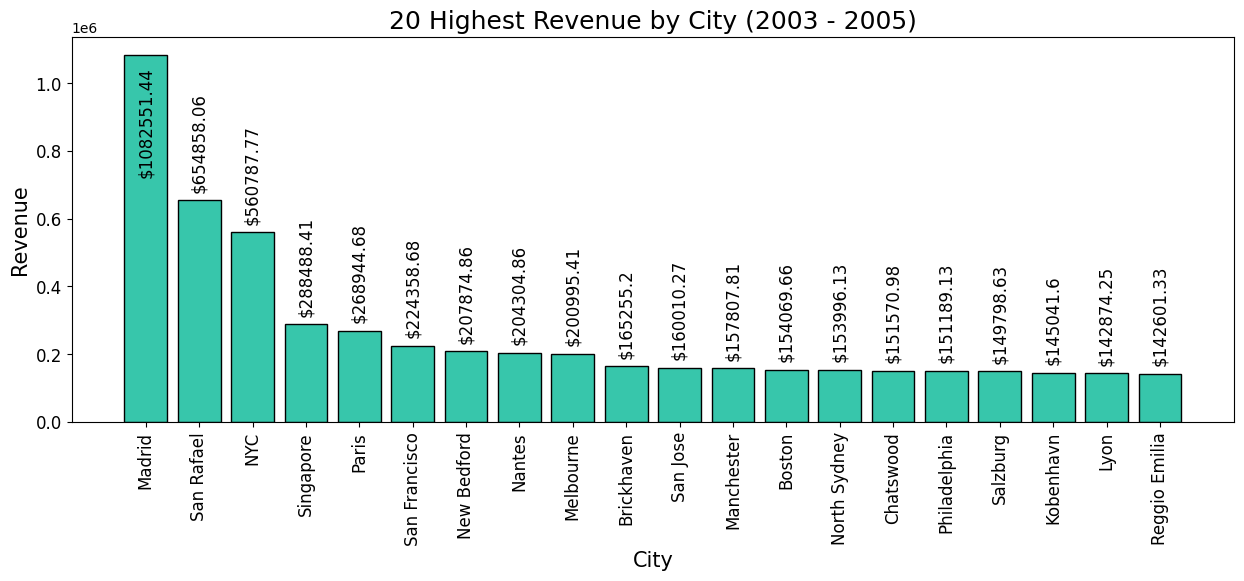

In [30]:
top_city = df.groupby(['CITY']).sum().sort_values('SALES', ascending = False).head(20)
top_city = top_city[['SALES']].round(3)
top_city.reset_index(inplace = True)
plt.figure(figsize = (15,5))
plt.title('20 Highest Revenue by City (2003 - 2005)', fontsize = 18)
plt.bar(top_city['CITY'], top_city['SALES'], color = '#37C6AB', edgecolor = 'black', linewidth = 1 )
plt.xlabel('City', fontsize = 15)
plt.ylabel('Revenue', fontsize = 15)
plt.xticks(fontsize = 12, rotation = 90)
plt.yticks(fontsize = 12)
for k, v, in top_city['SALES'].items():
    if v > 800000:
        plt.text(k, v-350000, '$' + str(v), fontsize = 12, rotation = 90, color = 'black', ha = 'center')
    else:
        plt.text(k, v+35000, '$' + str(v), fontsize = 12, rotation = 90, color = 'black', ha = 'center')

In [31]:
top_product = df.groupby(['PRODUCTLINE']).sum().sort_values('SALES', ascending = False)
top_product = top_product[['SALES']]
top_product.reset_index(inplace = True)
total_revenue_product = top_product['SALES'].sum()
total_revenue_product = str(int(total_revenue_product))
total_revenue_product = '$' + total_revenue_product

<ipython-input-31-4fdfc1b308e3>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  top_product = df.groupby(['PRODUCTLINE']).sum().sort_values('SALES', ascending = False)


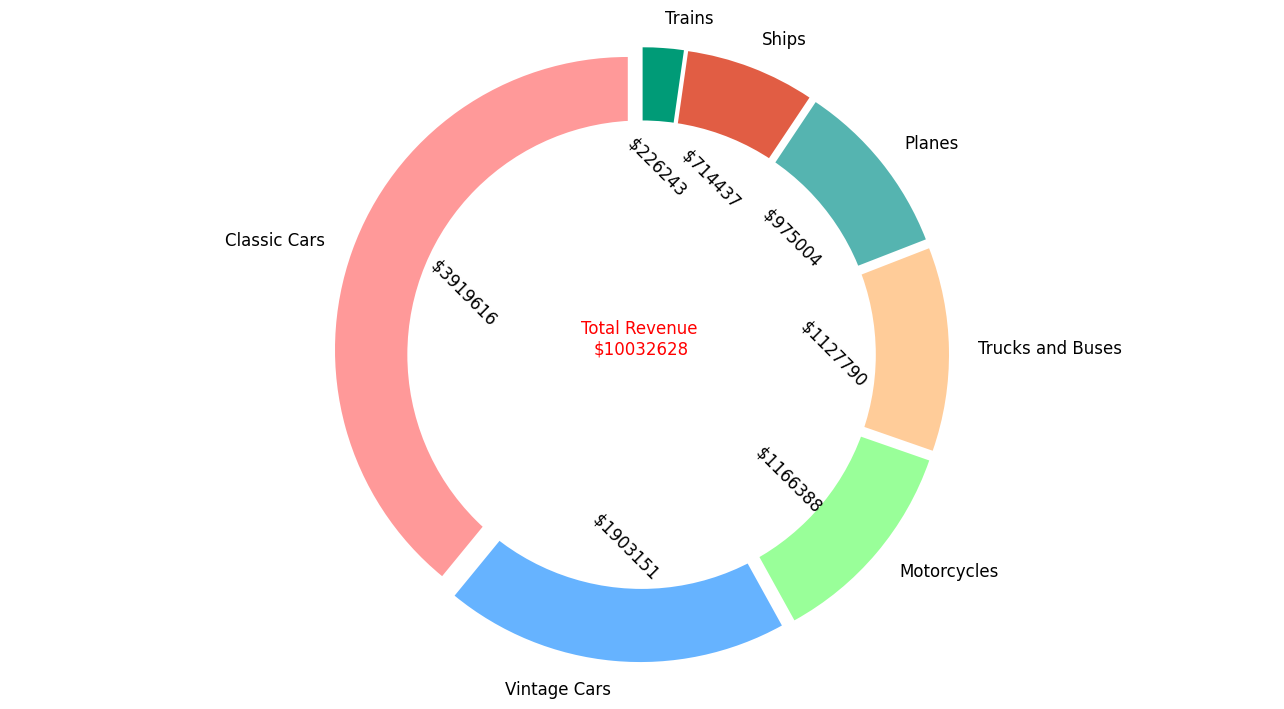

In [32]:
plt.rcParams['figure.figsize'] = (13,7)
plt.rcParams['font.size'] = 12.0
plt.rcParams['font.weight'] = 6
def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return ' ${v:d}'.format(v = val)
    return my_format
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#55B4B0','#E15D44','#009B77']
explode = (0.05,0.05,0.05,0.05,0.05,0.05,0.05)
fig1, ax1 = plt.subplots()
pie1 = ax1.pie(top_product['SALES'], colors = colors, labels = top_product['PRODUCTLINE'], autopct = autopct_format(top_product['SALES']), startangle = 90, explode = explode)
fraction_text_list = pie1[2]
for text in fraction_text_list:
    text.set_rotation(315)
center_circle = plt.Circle((0,0), 0.80, fc = 'white')
fig = plt.gcf()
fig.gca().add_artist(center_circle)
ax1.axis('equal')
label = ax1.annotate('Total Revenue \n' + str(total_revenue_product), color = 'red', xy = (0,0), fontsize = 12, ha  ='center')
plt.tight_layout()
plt.show()


<ipython-input-38-cd17c03abfb2>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


<Axes: >

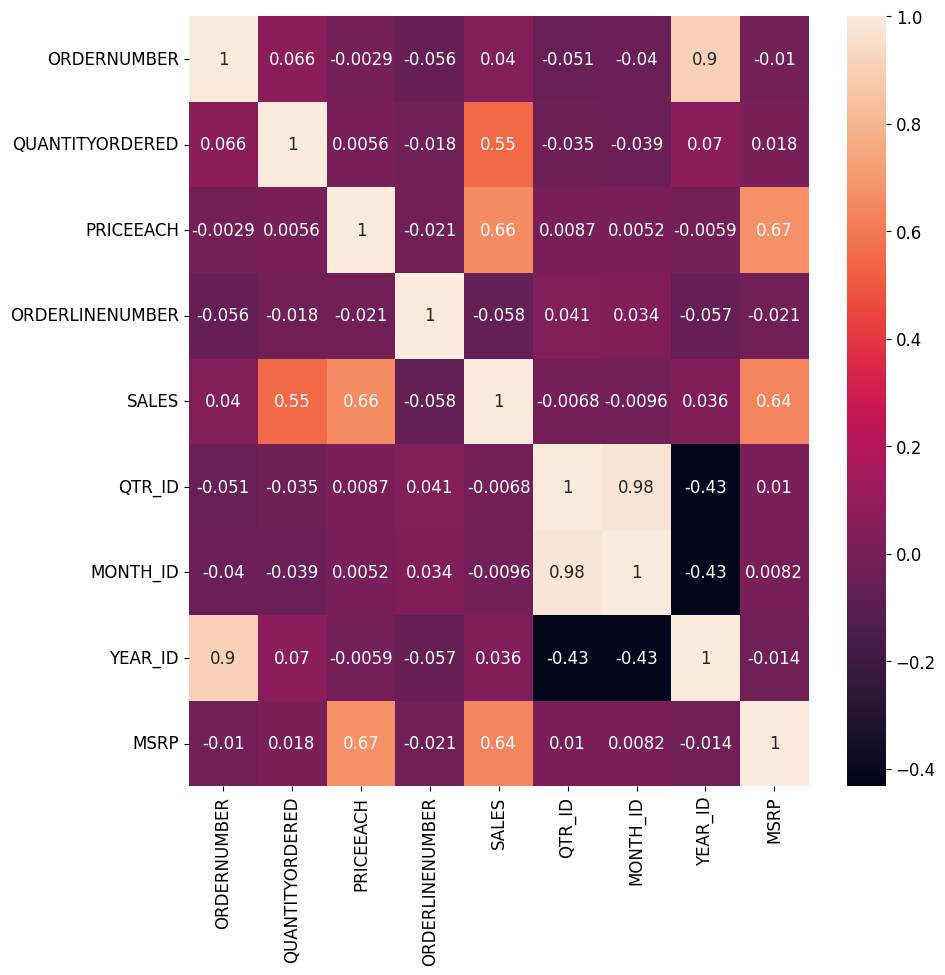

In [38]:
plt.figure(figsize = (10,10))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot = True)

<Axes: xlabel='PRODUCTLINE', ylabel='SALES'>

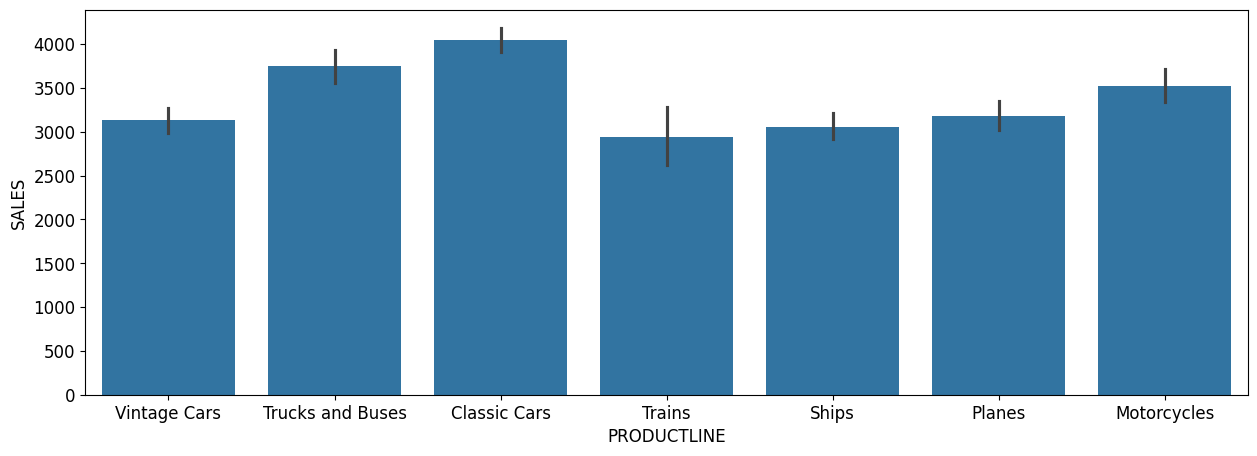

In [39]:
plt.figure(figsize=(15,5))
plt.tight_layout()
sns.barplot(x='PRODUCTLINE',y='SALES',data=df)

<Axes: xlabel='count', ylabel='STATUS'>

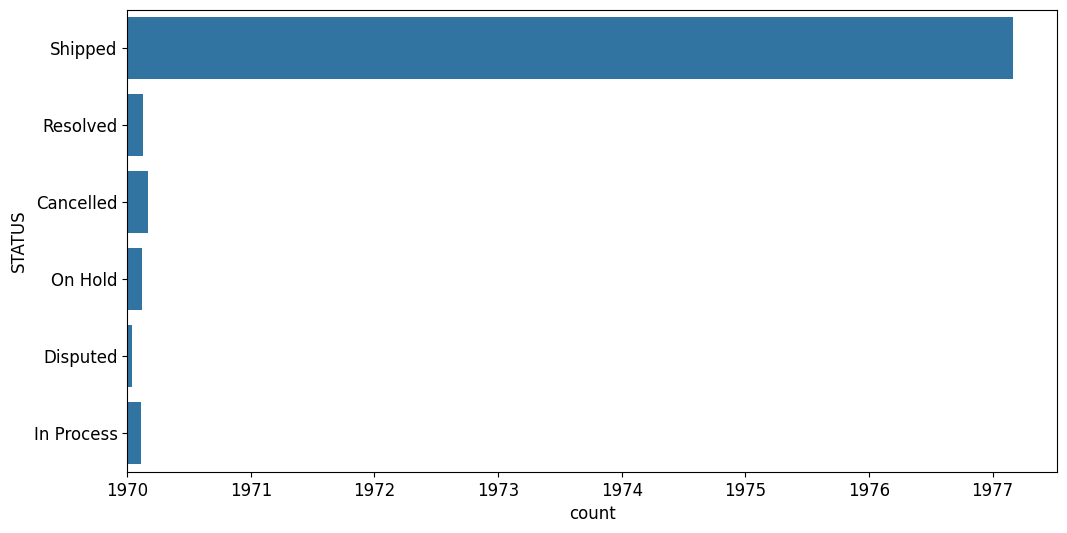

In [40]:
plt.figure(figsize=(12,6))
sns.countplot(df['STATUS'])

<Axes: xlabel='ORDERDATE', ylabel='SALES'>

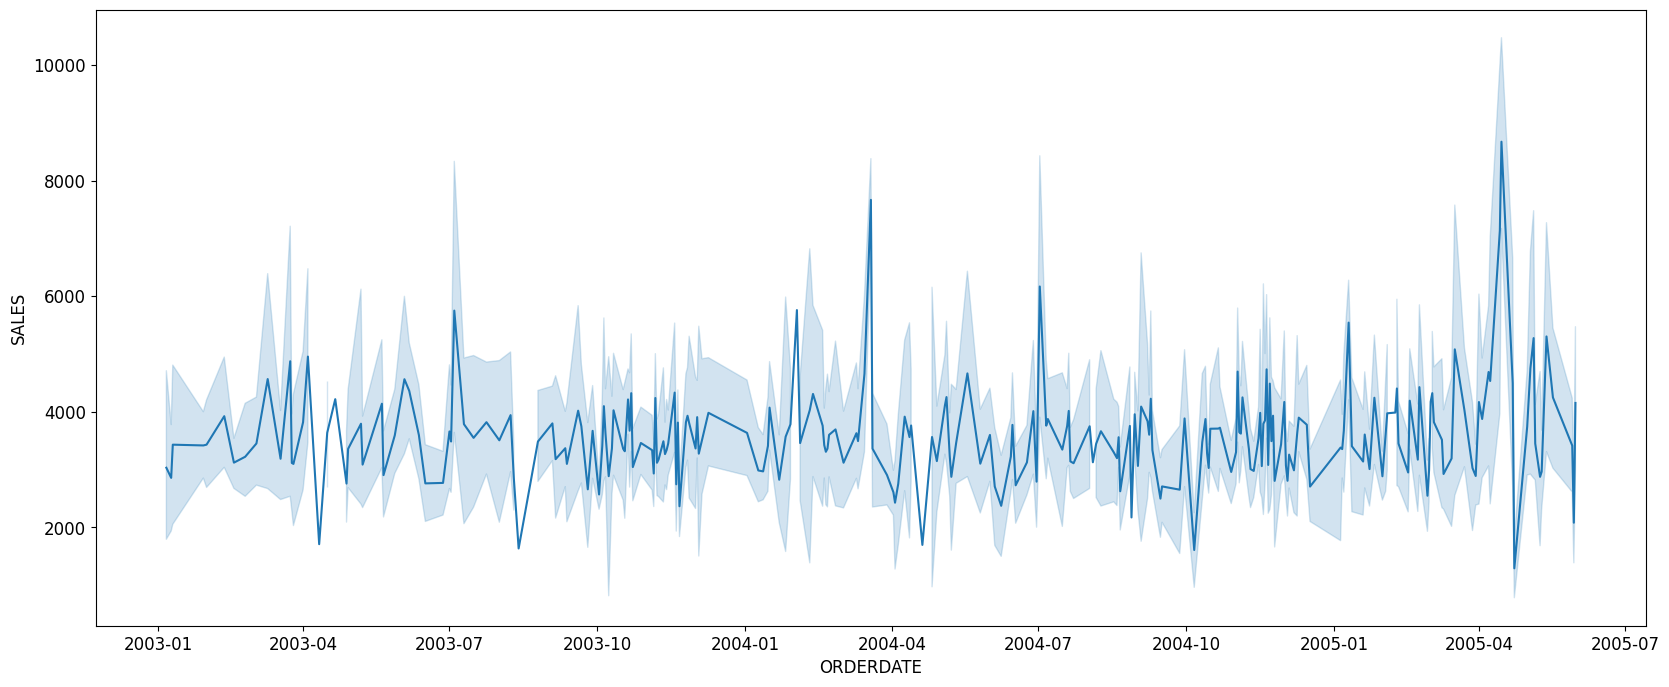

In [41]:
plt.figure(figsize=(20,8))
sns.lineplot(x='ORDERDATE', y='SALES', data=df)

## Feature Engineering

### Outlier detection

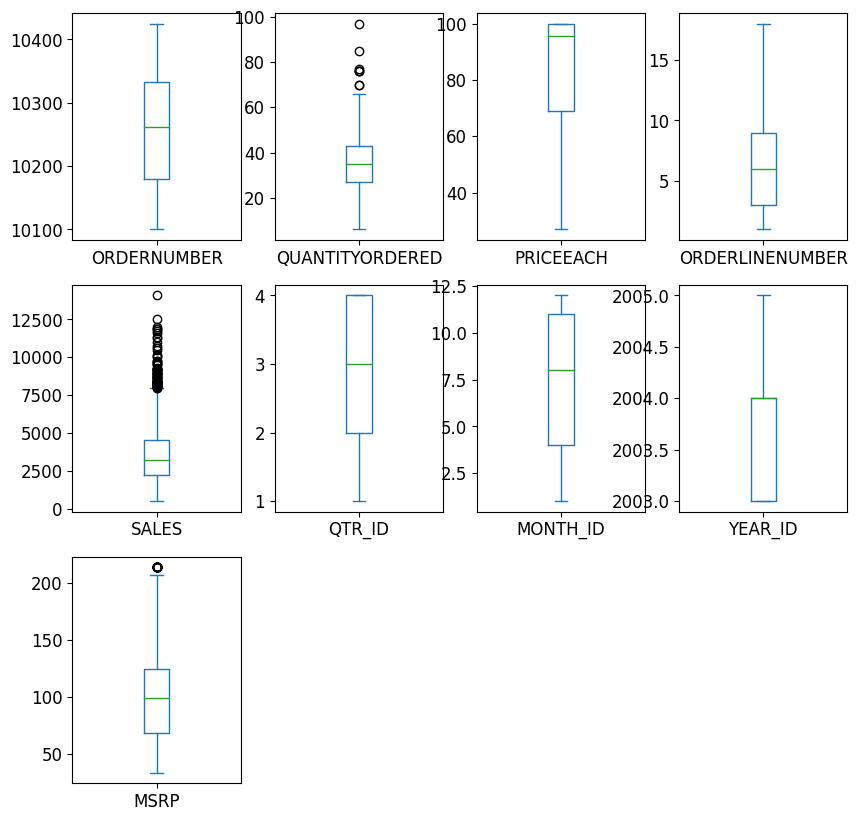

In [42]:
import matplotlib.pyplot as plt

df.plot(kind='box', subplots=True, sharex=False, sharey=False, figsize=(10,10), layout=(3,4))
plt.show()

### Filtering outlier

We can also use quartile ranges to filter for outliers. Let’s see an example of that below. We will be filtering rows that are outliers in all three variables

original shape of dataset : (2823, 18)
filtered dataset shape :  (2719, 18)


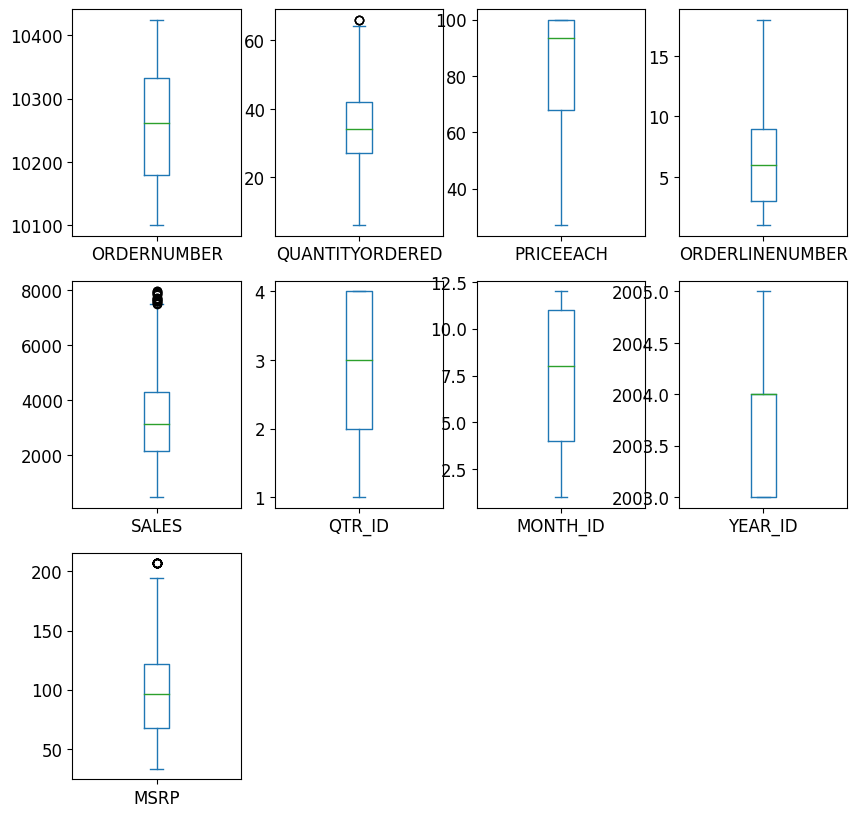

In [43]:
print('original shape of dataset :',df.shape)

cols = ['SALES', 'MSRP','QUANTITYORDERED']
new_df = df[cols]

#calculation
Q1 = new_df.quantile(0.25)
Q3 = new_df.quantile(0.75)
IQR = Q3-Q1
maximum = Q3+1.5*IQR
minimum = Q1-1.5*IQR
#print(minimum)

#filter outlier
cond = (new_df <= maximum) & (new_df >= minimum)

cond = cond.all(axis=1)
df = df[cond]
print('filtered dataset shape : ',df.shape)

#plot again to check that if has any outlier
df.plot(kind='box', subplots=True, sharex=False, sharey=False, figsize=(10,10), layout=(3,4))
plt.show()

### Scatter Plot

array([[<Axes: xlabel='SALES', ylabel='SALES'>,
        <Axes: xlabel='QUANTITYORDERED', ylabel='SALES'>,
        <Axes: xlabel='MSRP', ylabel='SALES'>],
       [<Axes: xlabel='SALES', ylabel='QUANTITYORDERED'>,
        <Axes: xlabel='QUANTITYORDERED', ylabel='QUANTITYORDERED'>,
        <Axes: xlabel='MSRP', ylabel='QUANTITYORDERED'>],
       [<Axes: xlabel='SALES', ylabel='MSRP'>,
        <Axes: xlabel='QUANTITYORDERED', ylabel='MSRP'>,
        <Axes: xlabel='MSRP', ylabel='MSRP'>]], dtype=object)

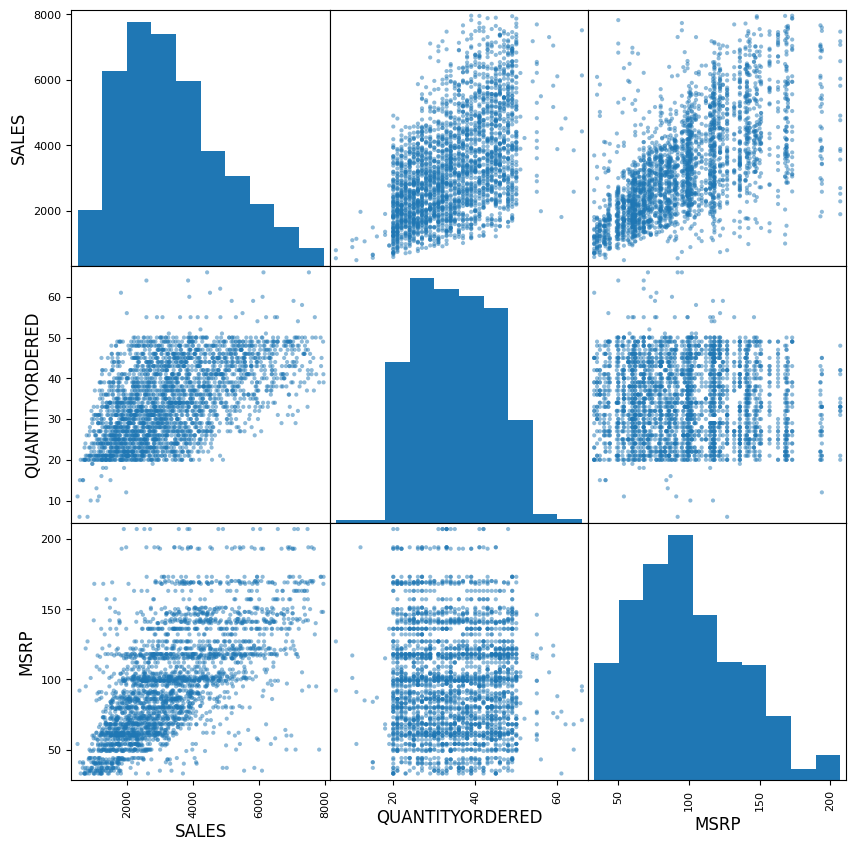

In [44]:
new_df = df[['SALES','QUANTITYORDERED','MSRP']]
pd.plotting.scatter_matrix(new_df, figsize = (10,10))

### Z-Score

A Z-score tells you how many standard deviations a specific value is away from the average (mean) of a dataset. It's a like a distance measure in statistics, highlighting how much a data point deviates from the norm. Z-scores are handy for spotting outliers – data points that fall far outside the pack. Additionally, they can't directly tell you about the data's spread, but they can be used in conjunction with other measures like standard deviation to understand how much the data varies.

shape of original data : (2719, 18)
shape of filtered data :  (2712, 3)


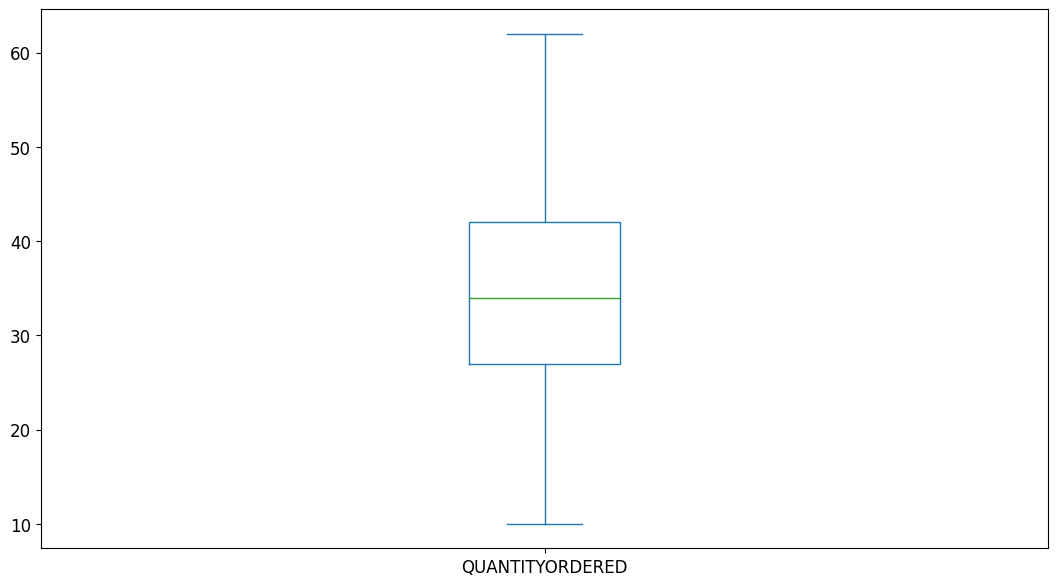

In [45]:
import numpy as np
print('shape of original data :',df.shape)

mean = new_df['QUANTITYORDERED'].mean()
std_dev = new_df['QUANTITYORDERED'].std()

# find z scores
z_scores = (new_df['QUANTITYORDERED'] - mean) / std_dev
z_scores = np.abs(z_scores)

#print(z_scores.min())

#filter data
z_df = new_df[z_scores<3]
print('shape of filtered data : ',z_df.shape)

#plot data
z_df['QUANTITYORDERED'].plot(kind='box')
plt.show()

 In normally distributed data, approximately 97% of the data lies inside 3 standard deviations.

## Advanced Analytics

In [46]:
print('Order Date Description\n')

df.sort_values(by = ['ORDERDATE'], inplace = True, ascending = True)

new_data = pd.DataFrame(df['SALES'])
new_data.head()

Order Date Description



SALES
ORDERDATE          
2003-01-06  5151.00
2003-01-06  3390.00
2003-01-06  1903.22
2003-01-06  1689.03
2003-01-09  1404.00

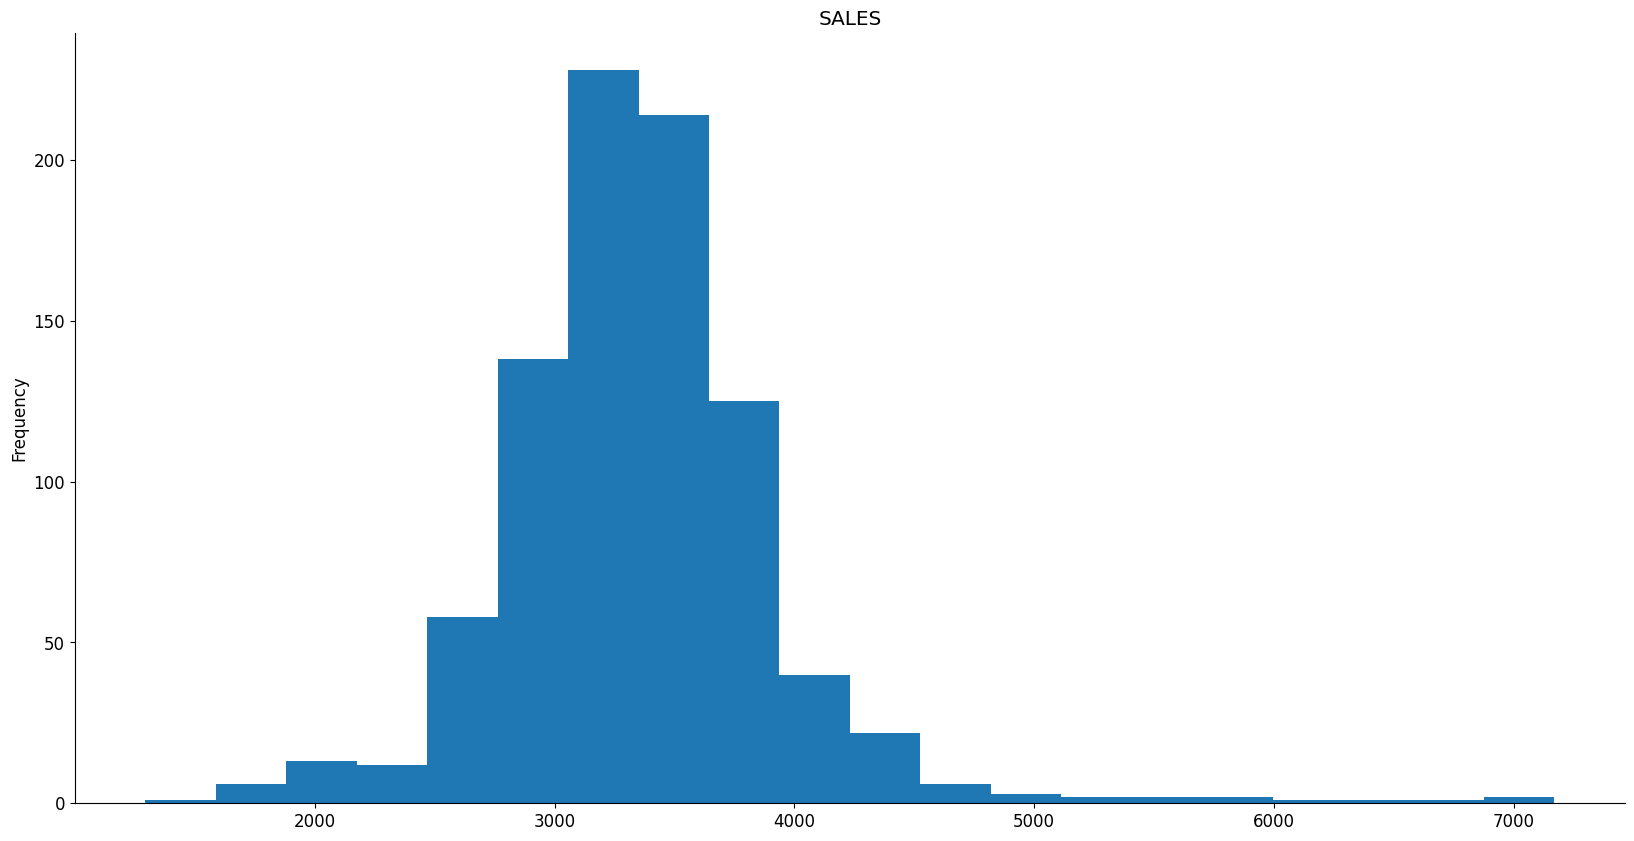

In [100]:
from matplotlib import pyplot as plt
new_data['SALES'].plot(kind='hist', bins=20, title='SALES')
plt.gca().spines[['top', 'right',]].set_visible(False)

<Axes: xlabel='ORDERDATE'>

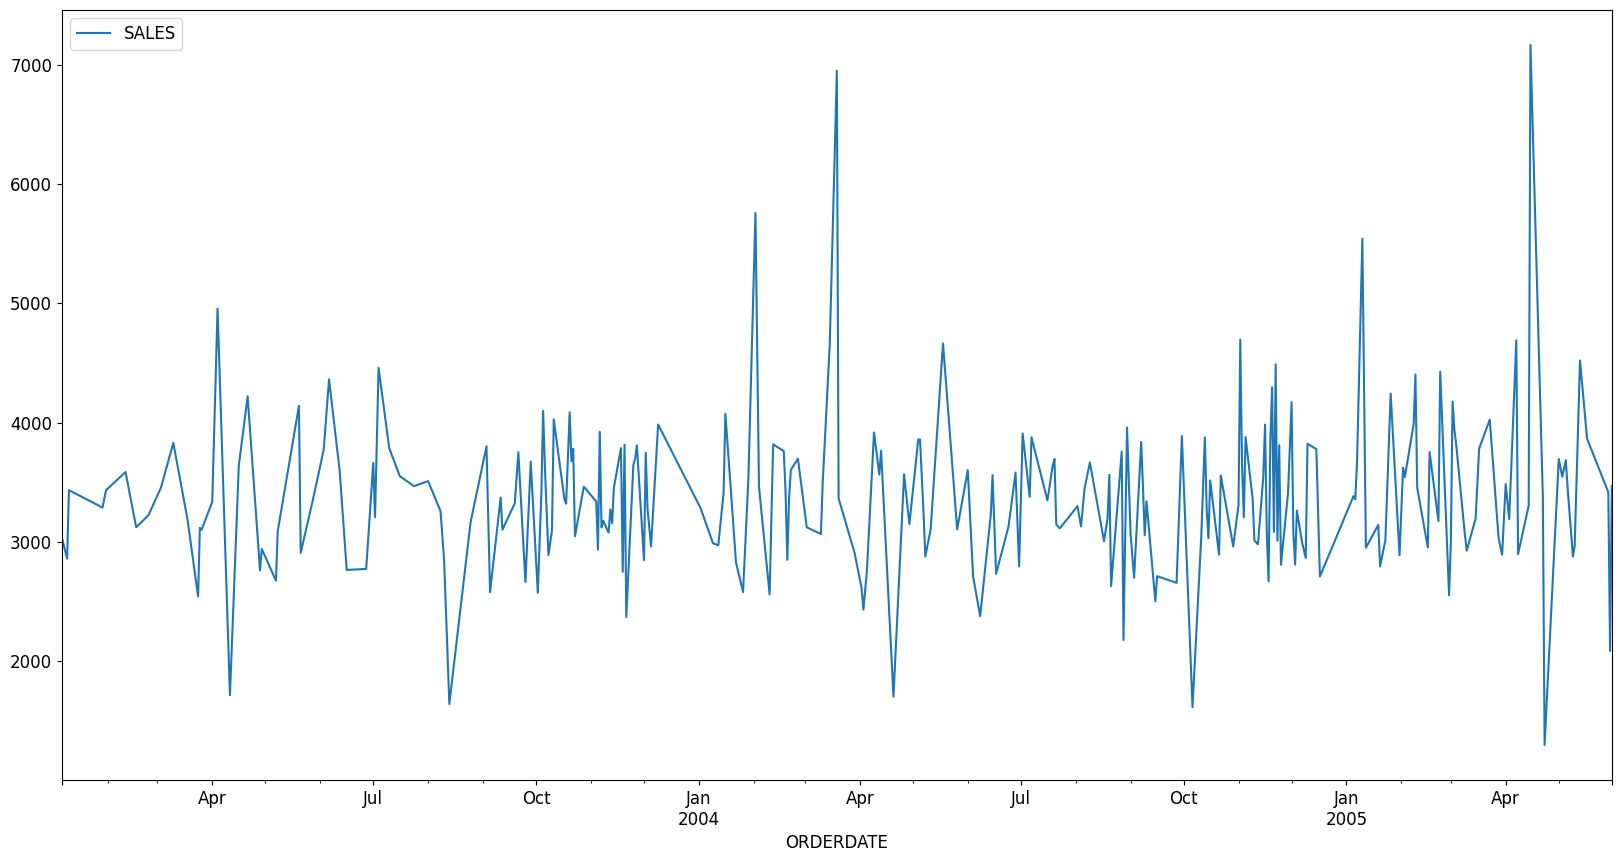

In [101]:
new_data.plot()

A time series is considered stationary if its average value (mean) and its variability (variance) remain consistent over time.  Looking at the sales data alone, it's hard to say for sure if it's stationary. To get a clearer picture, we can perform some stationarity tests and see if the sales pattern seems to hold steady over time.

### Checking for Stationary

In [49]:
new_data = pd.DataFrame(new_data['SALES'].resample('D').mean())
new_data = new_data.interpolate(method = 'linear')

#### Method 1<br/>

To check for stationarity by comparing the change in mean and variance over time, let us split teh data into train, test, and validation

In [50]:
train, test, validation = np.split(new_data['SALES'].sample(frac = 1), [int(.6*len(new_data['SALES'])), int(.8*len(new_data['SALES']))])

In [51]:
print('Train Dataset')
print(train)
print('Test Dataset')
print(test)
print('Validation Dataset')
print(validation)

Train Dataset
ORDERDATE
2004-07-28    3204.649957
2005-04-02    3336.150000
2004-02-03    4609.680714
2004-07-17    3444.151667
2004-07-02    3907.800000
                 ...     
2003-01-25    3317.130526
2003-05-29    3427.946146
2003-01-11    3424.365368
2003-03-21    2864.255000
2004-08-09    3664.378333
Name: SALES, Length: 526, dtype: float64
Test Dataset
ORDERDATE
2003-10-06    3625.300526
2003-10-31    3408.122017
2004-01-06    3112.521327
2003-04-24    3593.496122
2005-05-08    3067.480810
                 ...     
2004-06-16    3143.496944
2005-03-21    3943.396944
2004-06-19    2842.613194
2004-08-21    2626.574615
2005-04-06    4313.981250
Name: SALES, Length: 175, dtype: float64
Validation Dataset
ORDERDATE
2004-05-07    3239.832857
2004-01-30    4087.753333
2004-07-26    3167.298863
2003-03-28    3177.832963
2004-12-07    2988.413000
                 ...     
2004-09-12    3003.550286
2003-12-17    3749.114643
2004-09-09    3053.491429
2004-11-03    3646.107143
2003-02-27

While the means and variances across the three periods seem fairly consistent, relying solely on visual inspection isn't enough. To confirm our suspicions, let's perform a standard stationarity test called the Augmented Dickey-Fuller (ADF) test.

**The Augmented Dickey-Fuller Test Explained**
The ADF test is a statistical tool used to assess whether a time series has a trend, also known as a unit root. A unit root essentially means the data keeps increasing or decreasing forever. The test helps us determine if the series is stationary, meaning its mean and variance stay stable over time.

Here's how the test works:

- **Null Hypothesis (H0)**: The time series has a unit root, indicating non-stationarity.
- **Alternative Hypothesis (H1)**: The time series is stationary (no unit root).

We analyze the results using a p-value:
  - **p-value > 0.05**: We fail to reject the null hypothesis (H0). The data likely has a unit root and is non-stationary.
  - **p-value <= 0.05**: We reject the null hypothesis (H0). The data likely does not have a unit root and is stationary.

By running the ADF test, we'll gain a more statistically sound understanding of the series' stationarity.

#### Method 2 - Augmented Dicky Fuller Test

In [52]:
from statsmodels.tsa.stattools import adfuller
#statsmodel provied addfuller()
data1 = new_data.iloc[:,0].values
adf = adfuller(data1)

print(adf)
print('\nADF = ', str(adf[0]))
print('\np-value = ', str(adf[1]))
print('\nCritical Values: ')

for key, val in adf[4].items():
    print(key,':',val)
    if adf[0] < val:
        print('Null Hypothesis Rejected. Time Series is Stationary')
    else:
        print('Null Hypothesis Accepted. Time Series is not Stationary')

(-8.733960820726093, 3.1366811203981415e-14, 8, 868, {'1%': -3.4379061568421934, '5%': -2.864875519613169, '10%': -2.5685460785427594}, 12443.217492626418)

ADF =  -8.733960820726093

p-value =  3.1366811203981415e-14

Critical Values: 
1% : -3.4379061568421934
Null Hypothesis Rejected. Time Series is Stationary
5% : -2.864875519613169
Null Hypothesis Rejected. Time Series is Stationary
10% : -2.5685460785427594
Null Hypothesis Rejected. Time Series is Stationary


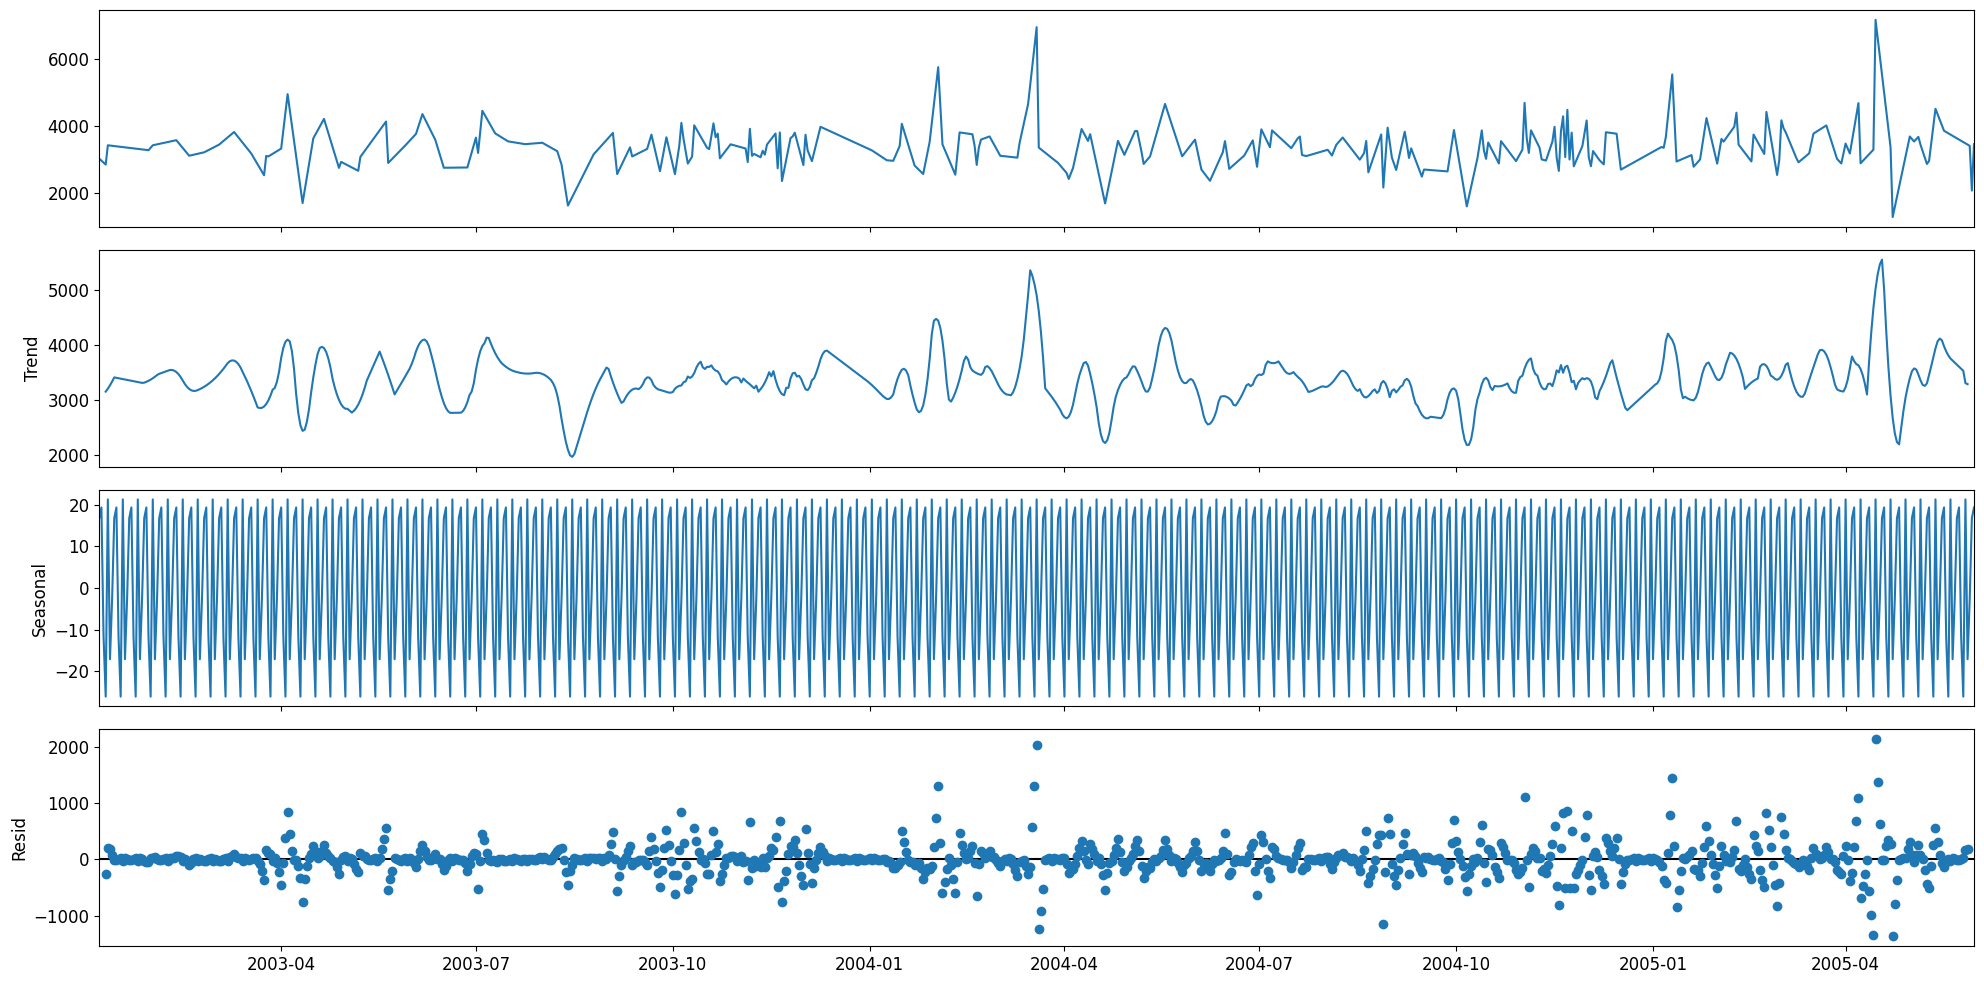

In [53]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(new_data, model = 'additive')

fig = decomposition.plot()
plt.show()

### Prediction

#### Using Linear Regression

In [82]:
from sklearn.preprocessing import LabelEncoder

le=LabelEncoder()

df['PRODUCTLINE'] = le.fit_transform(df['PRODUCTLINE'])
df['COUNTRY'] = le.fit_transform(df['COUNTRY'])

In [84]:
X = df.drop('SALES',axis=1)
y=df['SALES']

In [85]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

In [86]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()

In [87]:
lm.fit(X_train,y_train)

LinearRegression()

In [88]:
y_pred = lm.predict(X_test)

<Axes: xlabel='SALES'>

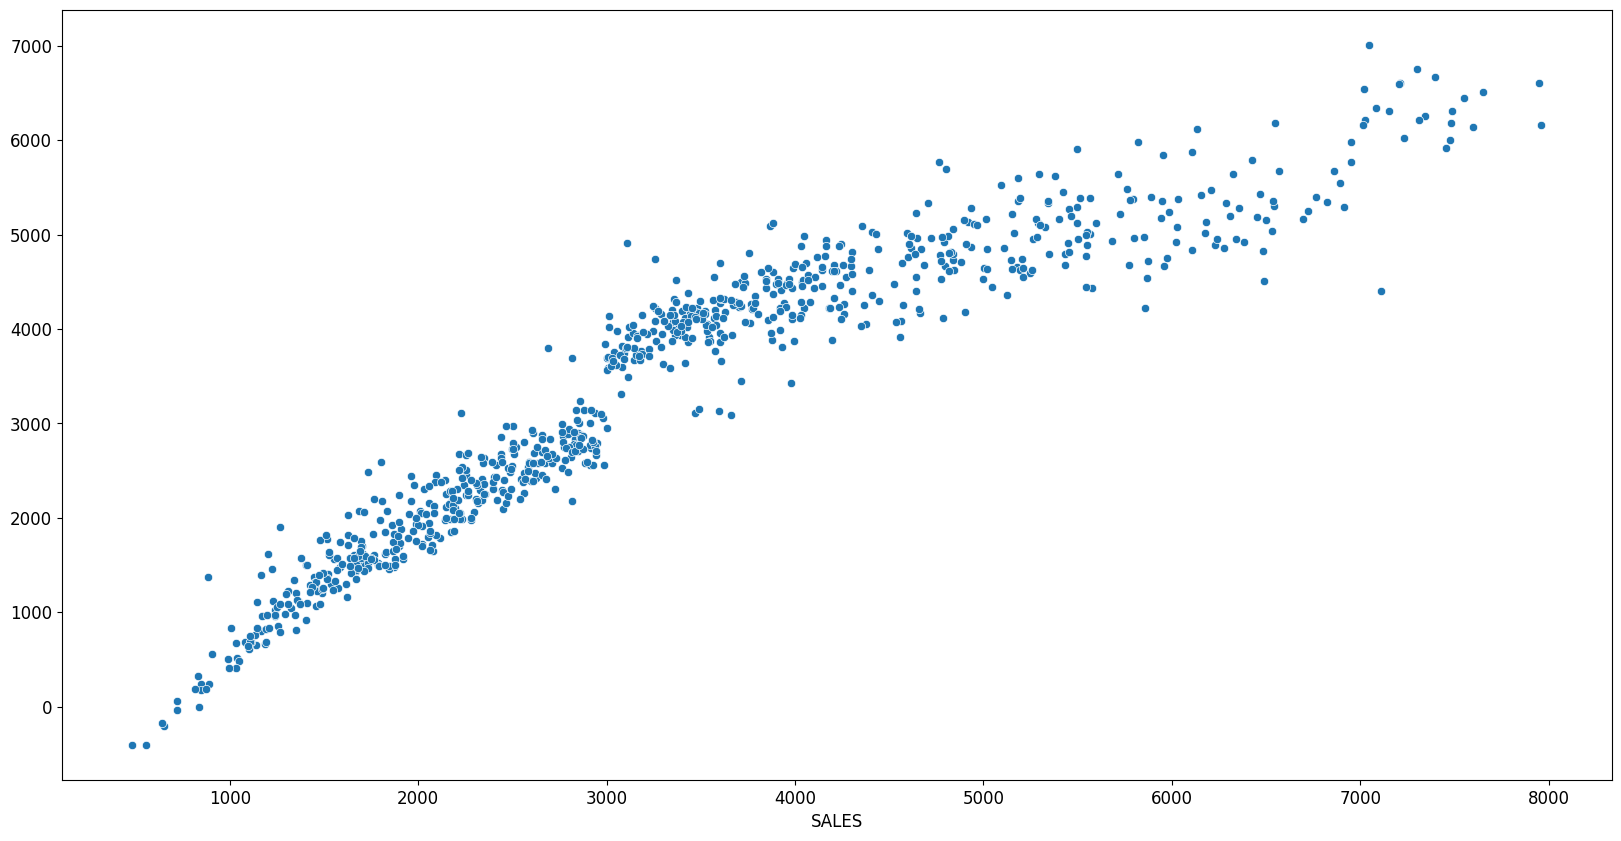

In [89]:
sns.scatterplot(x=y_test,y=y_pred)

In [91]:
print('Training Score :',lm.score(X_train, y_train))
print('Test Score     :',lm.score(X_test, y_test))

Training Score : 0.8634133365843661
Test Score     : 0.8786275014386424


#### Using LightGBM

In [54]:
from sklearn.preprocessing import LabelEncoder

def labelencoder(df):
    for c in df.columns:
        if df[c].dtype=='object':
            df[c] = df[c].fillna('N')
            lbl = LabelEncoder()
            lbl.fit(list(df[c].values))
            df[c] = lbl.transform(df[c].values)
    return df

In [55]:
data1=labelencoder(df)

In [56]:
target=['PRODUCTLINE']
dataY=data1[target]
dataX=data1.drop(target,axis=1)

In [57]:
df_columns = list(dataX.columns)
print(df_columns)

['ORDERNUMBER', 'QUANTITYORDERED', 'PRICEEACH', 'ORDERLINENUMBER', 'SALES', 'STATUS', 'QTR_ID', 'MONTH_ID', 'YEAR_ID', 'MSRP', 'PRODUCTCODE', 'CUSTOMERNAME', 'CITY', 'COUNTRY', 'CONTACTLASTNAME', 'CONTACTFIRSTNAME', 'DEALSIZE']


In [58]:
import random

m=len(dataX)
print(m)
M=list(range(m))
random.seed(2021)
random.shuffle(M)

trainX=dataX.iloc[M[0:(m//4)*3]]
trainY=dataY.iloc[M[0:(m//4)*3]]
testX=dataX.iloc[M[(m//4)*3:]]
testY=dataY.iloc[M[(m//4)*3:]]

2719


In [59]:
train_df=trainX
test_df=testX

In [60]:
train_df.columns=df_columns
test_df.columns=df_columns

In [61]:
def create_numeric_feature(input_df):
    use_columns = df_columns
    return input_df[use_columns].copy()

In [62]:
from contextlib import contextmanager
from time import time

class Timer:
    def __init__(self, logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None, sep=' '):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

In [63]:
from tqdm import tqdm

def to_feature(input_df):

    processors = [
        create_numeric_feature,
    ]

    out_df = pd.DataFrame()

    for func in tqdm(processors, total=len(processors)):
        with Timer(prefix='create' + func.__name__ + ' '):
            _df = func(input_df)

        assert len(_df) == len(input_df), func.__name__
        out_df = pd.concat([out_df, _df], axis=1)

    return out_df

In [64]:
train_feat_df = to_feature(train_df)
test_feat_df = to_feature(test_df)

100%|██████████| 1/1 [00:00<00:00, 217.14it/s]


createcreate_numeric_feature  0.002[s]


100%|██████████| 1/1 [00:00<00:00, 199.68it/s]

createcreate_numeric_feature  0.003[s]


Model

In [65]:
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor, early_stopping

def fit_lgbm(X, y, cv,
             params: dict=None,
             verbose: int=50):

    if params is None:
        params = {}

    models = []
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv):
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = LGBMRegressor(**params)
        early_stopping_callback = early_stopping(stopping_rounds=100)
        with Timer(prefix='fit fold={} '.format(i)):
            clf.fit(x_train, y_train,
                    eval_set=[(x_valid, y_valid)])

        pred_i = clf.predict(x_valid)
        oof_pred[idx_valid] = pred_i
        models.append(clf)
        print(f'Fold {i} RMSLE: {mean_squared_error(y_valid, pred_i) ** .5:.4f}')
        print()

    score = mean_squared_error(y, oof_pred) ** .5
    print('-' * 50)
    print('FINISHED | Whole RMSLE: {:.4f}'.format(score))
    return oof_pred, models

In [66]:
params = {
    'objective': 'rmse',
    'learning_rate': .1,
    'reg_lambda': 1.,
    'reg_alpha': .1,
    'max_depth': 5,
    'n_estimators': 10000,
    'colsample_bytree': .5,
    'min_child_samples': 10,
    'subsample_freq': 3,
    'subsample': .9,
    'importance_type': 'gain',
    'random_state': 71,
    'num_leaves': 62
}

In [67]:
y = trainY
ydf=pd.DataFrame(y)
ydf

PRODUCTLINE
ORDERDATE              
2005-02-17            6
2005-05-29            6
2003-01-31            4
2003-01-29            6
2004-03-15            0
...                 ...
2004-09-01            6
2005-02-10            0
2004-10-11            6
2004-02-22            0
2005-02-10            0

[2037 rows x 1 columns]

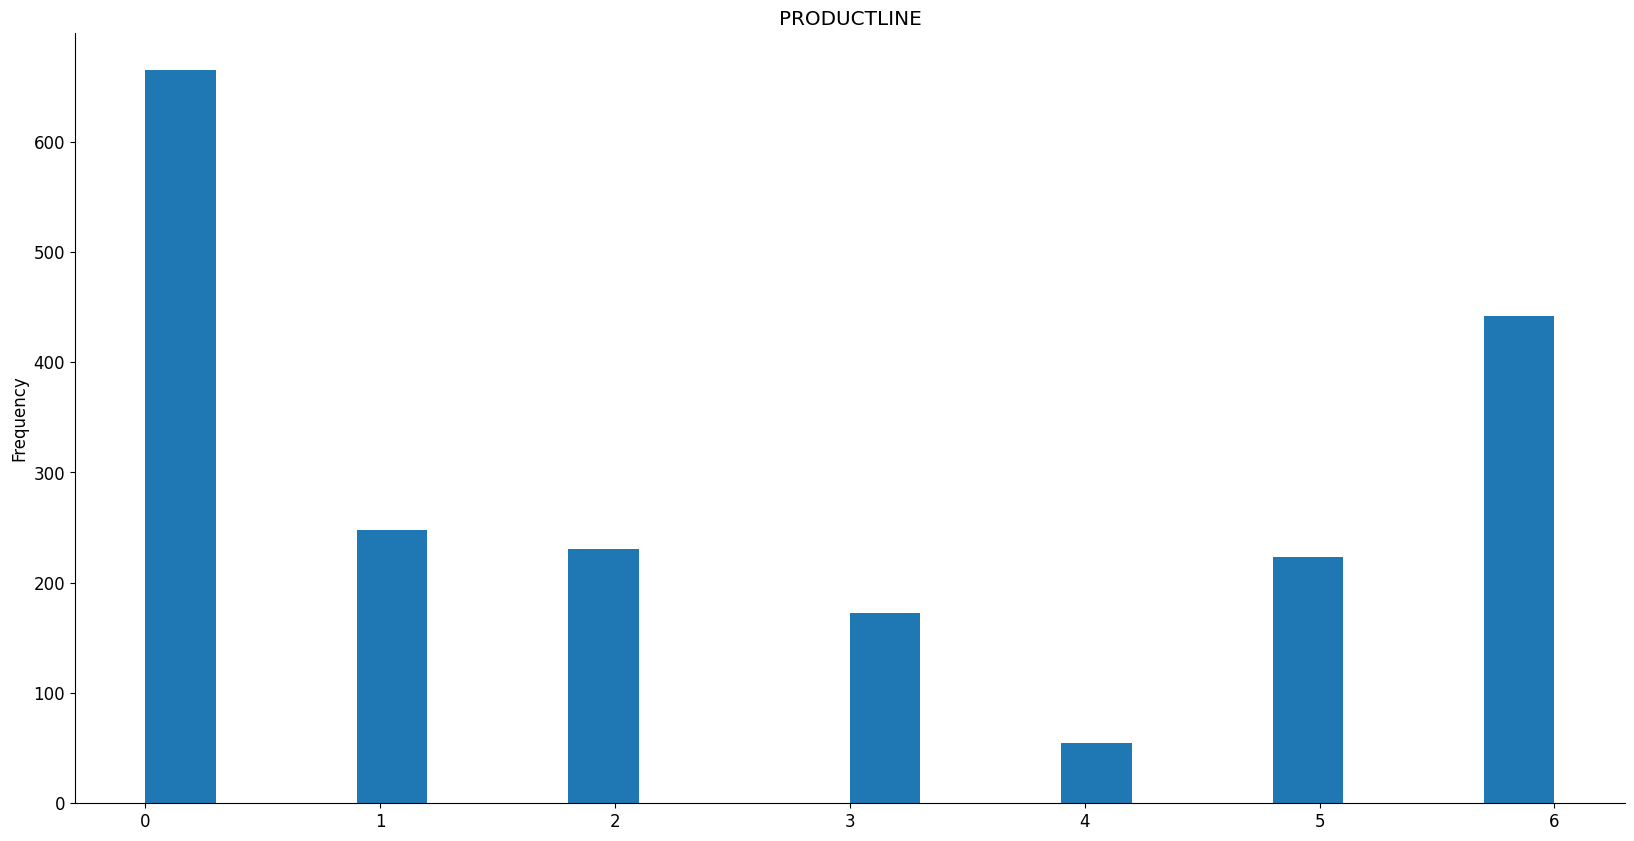

In [68]:
# PRODUCTLINE

from matplotlib import pyplot as plt
ydf['PRODUCTLINE'].plot(kind='hist', bins=20, title='PRODUCTLINE')
plt.gca().spines[['top', 'right',]].set_visible(False)

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there ar

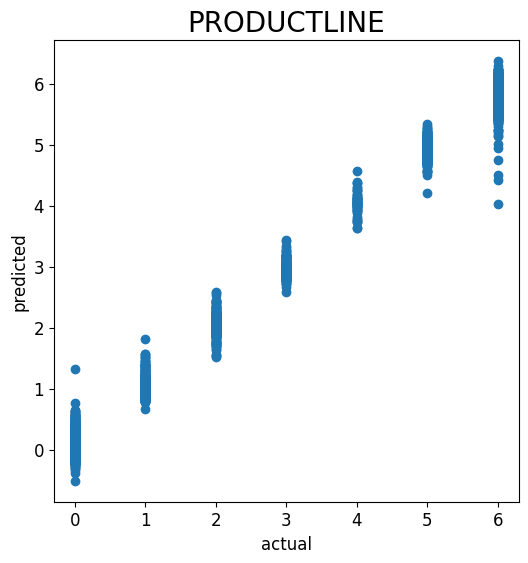

In [94]:

from sklearn.model_selection import KFold
np.float = float
from lightgbm import early_stopping


for i in range(1):
    fold = KFold(n_splits=5, shuffle=True, random_state=71)
    ydfi=ydf.iloc[:,i]
    y=np.array(ydfi)
    cv = list(fold.split(train_feat_df, y))
    oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params, verbose=500)

    fig,ax = plt.subplots(figsize=(6,6))
    ax.set_title(target[i],fontsize=20)
    ax.set_ylabel('predicted',fontsize=12)
    ax.set_xlabel('actual',fontsize=12)
    ax.scatter(y,oof)

## Visualize Importance

In [102]:
def visualize_importance(models, feat_train_df):

    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df],
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df,
                  x='feature_importance',
                  y='column',
                  order=order,
                  ax=ax,
                  palette='viridis',
                  orient='h')

    ax.tick_params(axis='x', rotation=0)
    #ax.set_title('Importance')
    ax.grid()
    fig.tight_layout()

    return fig,ax

#fig, ax = visualize_importance(models, train_feat_df)

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there ar

<ipython-input-102-67dda0b01841>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(data=feature_importance_df,


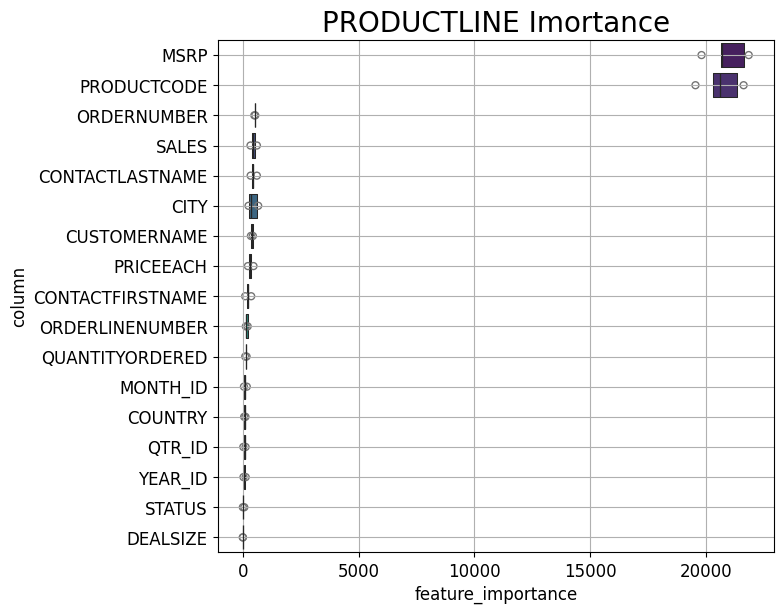

In [103]:
for i in range(1):
    fold = KFold(n_splits=5, shuffle=True, random_state=71)
    ydfi=ydf.iloc[:,i]
    y=np.array(ydfi)
    cv = list(fold.split(train_feat_df, y))
    oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params, verbose=500)
    fig, ax = visualize_importance(models, train_feat_df)
    ax.set_title(target[i]+' Imortance',fontsize=20)

In [104]:
preds=[]
for i in range(5):
    preds += [models[i].predict(test_feat_df.values)/5]
predsT=np.array(preds).T
preds2=[]
for item in predsT:
    value=sum(item)
    preds2+=[value]
print(preds2[0:5])

[0.127450304974689, 5.559013469901661, 0.26029922281802687, 0.5239366895961026, 0.07666276881777556]


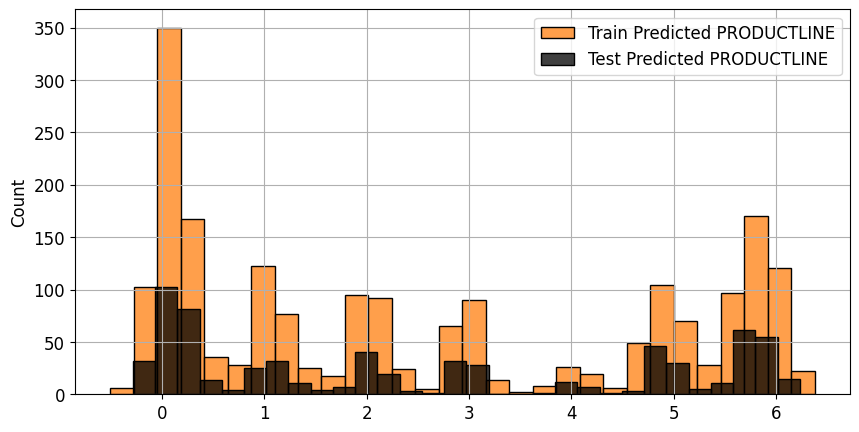

In [105]:
for i in range(1):
    fig, ax = plt.subplots(figsize=(10,5))
    sns.histplot(oof, label='Train Predicted '+target[i], ax=ax, color='C1',bins=30)
    sns.histplot(preds2, label='Test Predicted '+target[i], ax=ax, color='black',bins=30)
    ax.legend()
    ax.grid()

In [106]:
y_true=testY
y_pred=pd.Series(preds2).apply(lambda x: round(x,0))

In [107]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=raw_df['PRODUCTLINE'].unique().tolist(), digits=4))

                  precision    recall  f1-score   support

     Motorcycles     1.0000    0.9614    0.9803       233
    Classic Cars     0.8861    0.9859    0.9333        71
Trucks and Buses     0.9859    1.0000    0.9929        70
    Vintage Cars     1.0000    1.0000    1.0000        61
          Planes     1.0000    1.0000    1.0000        21
           Ships     0.8202    1.0000    0.9012        73
          Trains     1.0000    0.8954    0.9448       153

        accuracy                         0.9619       682
       macro avg     0.9560    0.9775    0.9647       682
    weighted avg     0.9675    0.9619    0.9627       682

